<div class="alert alert-success">
Laura Flores

This jupyter is just to call the Sentinel 1 data set, plot the 3 optiones(vv,vh,vv/vh) and then save the dataframe for the Time Series into a csv file
</div>

### Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

import shapely.wkt
import shapely.geometry
from shapely import wkt

import collections
collections.Callable = collections.abc.Callable

import warnings
warnings.filterwarnings('ignore')

In [2]:
import ee
# ee.Authenticate()

ee.Initialize()
print(ee.__version__)

import geemap

0.1.306


### Functions 

In [3]:
##Function to processing the data
from smooth_SG import *
from Gamma import *
from gee_functions import *

In [4]:
import matplotlib.pyplot as plt
import matplotlib.colors as cl
colors = plt.cm.viridis(np.linspace(0.1,0.9,8))
colors_hex = [cl.to_hex(c) for c in colors]

## shapefiles

### Change this fields

In [5]:
ID=1

if ID==1:
    ds = '2017-04-01' #start
    de = '2018-11-01' #end
    
if ID==2:
    ds = '2019-09-01' #start
    de = '2020-09-01' #end

if ID==8:
    ds = '2018-09-01' #start
    de = '2019-09-01' #end


-------------------------------------------
## Crops shapefiles

> El shapefile field_outlines contiene la informacion de aquellos sitios con datos detallados de cultivo. Esta informacion es para calibrar las series de tiempo. 
Ademas esta informacion esta en coordinadas geograficas 4326. Asi es como debe cargarde. Averiguar como se hace para trabajar en metricas sin que se genere un error

In [6]:
# label_fp='C:/Users/Flores/Documents/PythonScripts/codigos/Thesis/info_vectorial/Management/field_outlines/field_outlines.shp'
label_fp='C:/Users/Flores/Documents/PythonScripts/codigos/Thesis/info_vectorial/brandenburgo.shp'
# label_fp='C:/Users/Flores/Documents/PythonScripts/codigos/Thesis/info_vectorial/berlin.shp'
# now load the shapefile using geopandas and check it's projection
shapefile = gpd.read_file(label_fp)

# print the head
print(shapefile.head(10))

print('\nthere are {} labels'.format(len(shapefile)))

# shapefile = shapefile.to_crs({'init': 'epsg:25832'})
print('\nprojection is: {}'.format(shapefile.crs))

   GF  NUTS_LEVEL NUTS_CODE    NUTS_NAME  field id  \
0   4           1       DE4  Brandenburg         1   

                                            geometry  
0  POLYGON ((13.58985 51.38423, 13.58812 51.38459...  

there are 1 labels

projection is: epsg:4326


En la siguiente linea elijo que poligonos seran usados

In [7]:
test2=shapefile.loc[(shapefile['field id']==ID)]
test2

,GF,NUTS_LEVEL,NUTS_CODE,NUTS_NAME,field id,geometry
0,4,1,DE4,Brandenburg,1,"POLYGON ((13.58985 51.38423, 13.58812 51.38459..."



and this shape looks like:


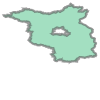

In [8]:
geoms_test2 = pd.DataFrame(test2['geometry'])
# (geoms_test2.info())

# this generates a list of shapely geometries
geoms_test2 = test2.geometry.values 
# to show you what this looks like let's grab a random polygon in the shapefile
geometry_test2 = geoms_test2[0] 
print('\nand this shape looks like:')
geometry_test2

In [9]:
list_wkt = test2.geometry.apply(lambda x: wkt.dumps(x))
# list_wkt

list_polygons =  [shapely.wkt.loads(poly) for poly in list_wkt]
list_polygons
list_multipolygons= shapely.geometry.multipolygon.MultiPolygon(list_polygons) 
list_multipolygons.centroid.x
# cenxp2, cenyp2 = list_polygons.centroid.x, list_polygons.centroid.y

13.39777822485927

In [10]:
# shapely.geometry.multipolygon.MultiPolygon?

In [11]:
cenxp2, cenyp2 = list_multipolygons.centroid.x, list_multipolygons.centroid.y
aoi_geep2 = gee_geometry_from_shapely(list_multipolygons)

Centroid = ee.Geometry.Point([(list_multipolygons.centroid.x), list_multipolygons.centroid.y])
clipper = Centroid.buffer(3000) #This is in METERS

print(cenxp2, cenyp2)

13.39777822485927 52.47288566703508


## Sentinel 1
A continuacion se carga la imagen sentinel 1. 

Se tratara de cortar a solo el sector de estudio

In [12]:
start_date = ds
end_date = de

# // get the data from Sentinel-1 collection, for our area and period of interest
S11 = ee.ImageCollection('COPERNICUS/S1_GRD')\
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))\
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))\
        .filter(ee.Filter.eq('instrumentMode', 'IW'))\
        .filterBounds(aoi_geep2)\
        .filterDate(ds, de)\
        .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))\
        .map(maskBorder)\
        .map(applyGamma)\
        .map(terrainCorrection)


In [13]:
# images = S1.toList(S1.size())
# num_images = len(images.getInfo())
# print(num_images)

In [14]:
# S1.getInfo()

In [15]:
def toNatural(img):
    return ee.Image(10.0).pow(img.select('..').divide(10.0)).copyProperties(img, ['system:time_start'])

def make_ratio(image):
    ratio = image.select('VH').divide(image.select('VV')).rename('VHdVV')
    return image.addBands(ratio)

def make_RVI(image):
    ratio = (image.select('VH').multiply(4)).divide(image.select('VV').add(image.select('VH'))).rename('RVI')
    return image.addBands(ratio)

def addDOY(image):
    doy = image.date().getRelative('day', 'year');
    doyBand = ee.Image.constant(doy).uint16().rename('DOY');
    return image.addBands(doyBand);


S1 =S11.map(toNatural)
S1=S1.map(make_ratio)
S1=S1.map(make_RVI)
# S1 = S1.map(addDOY)

                                                                 
S1_VV= S1.select('VV')#.map(addDOY)
S1_VH= S1.select('VH')#.map(addDOY)
S1_VHVV=S1.select('VHdVV')#.map(addDOY)
S1_RVI=S1.select('RVI')#.map(addDOY)

In [16]:
# S1.getInfo()

In [17]:
# S1_VHVV.getInfo()

In [18]:
# smoothSG=apply_SG(S1, window_size=5, order=3)
S1_VVSG=apply_SG(S1_VV, window_size=5, order=3)
S1_VHSG=apply_SG(S1_VH, window_size=5, order=3)
S1_VHVVSG=apply_SG(S1_VHVV, window_size=5, order=3)
S1_RVISG=apply_SG(S1_RVI, window_size=5, order=3)

In [19]:
# S1_VHVVSG.getInfo()

In [20]:
def copyProps(index):
    source = ee.Image(S1_VHVV.toList(S1_VHVV.size()).get(index))
    dest = ee.Image(S1_VHVVSG.toList(S1_VHVVSG.size()).get(index))
    image = ee.Image(source.copyProperties(dest))
    return image

seq = ee.List.sequence(0, S1_VHVVSG.size().subtract(1))
S1_VHVVSG = ee.ImageCollection(seq.map(copyProps))

In [21]:
# S1_VHVVSG.getInfo()

# Map SG

In [22]:
S1_VHVVSG_clip = S1_VHVVSG.map(lambda image: image.clip(aoi_geep2))
listOfImages =S1_VHVVSG_clip.toList(S1_VHVVSG_clip.size())
firstImage = ee.Image(listOfImages.get(0));
secondImage = ee.Image(listOfImages.get(10));

lastImage = ee.Image(listOfImages.get(15));
# ee.Image(listOfImages.get(listOfImages.length().subtract(1)));

In [23]:
# secondImage.getInfo()

In [24]:
# clipped = smoothSG.map(lambda image: image.clip(aoi_geep2))

In [25]:
# Map = geemap.Map(center=[cenyp2, cenxp2], zoom=8)
# Map.addLayer(firstImage.select('VHdVV'),{min: [0], max: [10],'palette': colors_hex}, 'first image')
# Map.addLayer(secondImage.select('VHdVV'),{min: [0], max: [10],'palette': colors_hex}, 'second image')
# Map.addLayer(lastImage.select('VHdVV'),{min: [0], max: [10],'palette': colors_hex}, 'last image')

# Map.addLayer(clipped.first(),{min: [0], max: [10]}, 'collection VV')##, 'palette': colors_hex
# Map.addLayer(clippedvvvhsg,{min: [0, 0, -25], max: [10, 10, 5]}, 'collection VH/VV')##, 
# Map

## probando con la funcion yearly

In [26]:
def DOYS(img):
    fitted = img.select(["VHdVV"])
    timestamp = img.metadata('system:time_start')
#     doy = ee.Image.constant(ee.Number.parse(ee.Date(ds).getRelative("day","years")))
#     doy_austral = ee.Image(ee.Number.parse(img.date().getRelative("day","years")).subtract(enddoy)).uint16()
    doy_austral = ee.Image.constant(ee.Number.parse(img.date().format("D"))).rename('day').toUint32()
#     doy_austral =  ee.Image(ee.Number.parse(ee.Date(ds).format("D"))).rename('day').subtract(enddoy).uint16()
    return fitted.addBands(timestamp).addBands(doy_austral).rename('VHdVV','timestamp', 'DOY')


In [27]:
S1_VHVV_d=S1_VHVV.map(DOYS)
# S1_VHVV_d.getInfo()

### Curva de tiempo para saber si el DOY esta bien asignado

In [28]:
# S1_DOY_a= data_asc.select('DOY')
# S1_VHVV_a= data_asc.select('VH')

In [29]:
# mean_VHVV = export_to_pandas(S1_VHVV_d, clipper=aoi_geep2, aggregation_scale=10, med='mean')

In [30]:
# mean_VH=mean_VHVV[0]#np.concatenate([mean_std_VH_a[0],mean_std_VH_d[0]])

# date_mean=mean_VHVV[0].index#np.concatenate([mean_std_VV_a[0].index,mean_std_VV_d[0].index])

In [31]:
# date_mean= date_mean[~(np.isnan(mean_VH))]
# mean_VH= mean_VH[~(np.isnan(mean_VH))]

# date_mean= date_mean[~(np.isnan(mean_VH))]

In [32]:
# df=pd.DataFrame({'DOY':mean_VH,
#                  'Date':date_mean})

# df=df.sort_values(by=['Date'])

In [33]:
# df=df.reset_index()
# df

Demostrado en el dataframe anterior. Está desde el 1ro de enero 

### Calculo de las mapas por SAS,EOS,Max

In [34]:
S1_VHVVSG_clip = S1_VHVV_d#.map(lambda image: image.clip(aoi_geep2))
banda='VHdVV'
def yearly(y):
    start = ee.Date.fromYMD(2018, 1, 1)
    stop = start.advance(1,'year')
#     fittedNDVIandTimes = S1_VHVVSG.filterDate(start, stop)
    fittedNDVIandTimes =S1_VHVVSG_clip
# //Get maximum NDVI and doy and date at which it occurs
##el problema esta en las siguientes 2 lineas

    maxNDVItime=fittedNDVIandTimes.select([banda, 'DOY']).reduce(ee.Reducer.max(2)).rename('maxV', 'maxDoy');

# //Get minimum NDVI and doy and date at which it occurs
    minNDVItime=fittedNDVIandTimes.select([banda, 'DOY']).reduce(ee.Reducer.min(2)).rename('minV', 'minDoy');

# //Calculate the mid-point. 
    midpoint = maxNDVItime.select('maxV').add(minNDVItime.select('minV')).divide(2);
#     midpoint_VH = maxNDVItime.select('maxVH').add(minNDVItime.select('minVH')).divide(2);
# //masks all values after season maximum
    def mascara_after(img):
        preMask=img.select('DOY').lte(maxNDVItime.select('maxDoy'))
        return img.updateMask(preMask)


    preSeasonMax= fittedNDVIandTimes.map(mascara_after)

# //mask all values previous to season max
    def mascara_before(img):
        postMask=img.select('DOY').gt(maxNDVItime.select('maxDoy'))
        return img.updateMask(postMask)

    postSeasonMax= fittedNDVIandTimes.map(mascara_before)

    def addMidpointProximity(img):
        midpointProxNeg = img.select([banda]).subtract(midpoint).abs().multiply(-1).rename('midpointProxNeg')
        return img.addBands(midpointProxNeg)



    forSOSretrieval = preSeasonMax.map(addMidpointProximity)

    forEOSretrieval = postSeasonMax.map(addMidpointProximity)

# //composite images based on NDVI minimal distance from midpoint. 
    SOSmidp= forSOSretrieval.qualityMosaic('midpointProxNeg')
    EOSmidp= forEOSretrieval.qualityMosaic('midpointProxNeg')
    LOSmidp = EOSmidp.select('DOY').subtract(SOSmidp.select('DOY'))


    LSP = SOSmidp.select("DOY").addBands(EOSmidp.select("DOY")).addBands(LOSmidp.select("DOY"))\
            .rename('SOS','EOS', 'LOS').set('year', y,"system:time_start", start.millis(),"system:time_end", stop.millis());

    return LSP
  

In [35]:
# years = ee.List.sequence(2018, 2018)

In [36]:
# LSP2 = ee.ImageCollection(years.map(yearly))
# # LSP2.getInfo()

In [37]:
# LSP_ORG = LSP2.map(lambda image: image.clip(aoi_geep2))

In [38]:
# Map = geemap.Map(center=[cenyp2, cenxp2], zoom=12)

# Map.addLayer(aoi_geep2)
# Map.addLayer(LSP_ORG.first(),{'bands': ['SOS'],min: 1, max: 365, 'palette': colors_hex}, "SOSSG")


# Map

In [39]:
# LSP_ORG_SOS=LSP_ORG.select('SOS')
# list_LSP_ORG_SOS =LSP_ORG_SOS.toList(LSP_ORG_SOS.size())
# LSP_ORG_SOS_2018 = ee.Image(list_LSP_ORG_SOS.get(0))
# LSP_ORG_SOS_2019 = ee.Image(list_LSP_ORG_SOS.get(1))
# LSP_ORG_SOS_2020 = ee.Image(list_LSP_ORG_SOS.get(2))

In [40]:
# # ## SOS
# ee.batch.Export.image.toDrive(image =  LSP_ORG_SOS_2017, 
#                               fileNamePrefix = 'LSP_ORG_SOS_2017', 
#                               description= ('LSP_ORG_SOS_2017'),  
#                               folder = "thesis", region = aoi_geep2, 
#                               scale=8, maxPixels= 4294967295).start()

# ee.batch.Export.image.toDrive(image =  LSP_ORG_SOS_2019, 
#                               fileNamePrefix = 'LSP_ORG_SOS_2019', 
#                               description= ('LSP_ORG_SOS_2019'),  
#                               folder = "thesis", region = aoi_geep2, 
#                               scale=8,maxPixels= 4294967295).start()

# ee.batch.Export.image.toDrive(image =  LSP_ORG_SOS_2020, 
#                               fileNamePrefix = 'LSP_ORG_SOS_2020', 
#                               description= ('LSP_ORG_SOS_2020'),  
#                               folder = "thesis", region = aoi_geep2, 
#                               scale=8, maxPixels= 4294967295).start()

In [41]:
# # ## EOS

# LSP_ORG_EOS=LSP_ORG.select('EOS')
# list_LSP_ORG_EOS =LSP_ORG_EOS.toList(LSP_ORG_EOS.size())
# LSP_ORG_EOS_2018 = ee.Image(list_LSP_ORG_EOS.get(0))
# LSP_ORG_EOS_2019 = ee.Image(list_LSP_ORG_EOS.get(1))
# LSP_ORG_EOS_2020 = ee.Image(list_LSP_ORG_EOS.get(2))

# ee.batch.Export.image.toDrive(image =  LSP_ORG_EOS_2017, 
#                               fileNamePrefix = 'LSP_ORG_EOS_2017', 
#                               description= ('LSP_ORG_EOS_2017'),  
#                               folder = "thesis", region = aoi_geep2, 
#                               scale=8,maxPixels= 4294967295).start()

# ee.batch.Export.image.toDrive(image =  LSP_ORG_EOS_2019, 
#                               fileNamePrefix = 'LSP_ORG_EOS_2019', 
#                               description= ('LSP_ORG_EOS_2019'),  
#                               folder = "thesis", region = aoi_geep2, 
#                               scale=8, maxPixels= 4294967295).start()

# ee.batch.Export.image.toDrive(image =  LSP_ORG_EOS_2020, 
#                               fileNamePrefix = 'LSP_ORG_EOS_2020', 
#                               description= ('LSP_ORG_EOS_2020'),  
#                               folder = "thesis", region = aoi_geep2, 
#                               scale=8,maxPixels= 4294967295).start()

### SG 

In [42]:
collectionFromImagesVHVV_SG=S1_VHVVSG.map(DOYS)

In [43]:
S1_VHVVSG_clip = collectionFromImagesVHVV_SG.map(lambda image: image.clip(aoi_geep2))

banda='VHdVV'
def yearly(y):
    start = ee.Date.fromYMD(2017, 1, 1)
    stop = start.advance(1,'year')
#     fittedNDVIandTimes = S1_VHVVSG.filterDate(start, stop)
    fittedNDVIandTimes =S1_VHVVSG_clip#collectionFromImagesVHVV_SG
# //Get maximum NDVI and doy and date at which it occurs
##el problema esta en las siguientes 2 lineas

    maxNDVItime=fittedNDVIandTimes.select([banda, 'DOY']).reduce(ee.Reducer.max(2)).rename('maxV', 'maxDoy');

# //Get minimum NDVI and doy and date at which it occurs
    minNDVItime=fittedNDVIandTimes.select([banda, 'DOY']).reduce(ee.Reducer.min(2)).rename('minV', 'minDoy');

# //Calculate the mid-point. 
    midpoint = maxNDVItime.select('maxV').add(minNDVItime.select('minV')).divide(2);
#     midpoint_VH = maxNDVItime.select('maxVH').add(minNDVItime.select('minVH')).divide(2);
# //masks all values after season maximum
    def mascara_after(img):
        preMask=img.select('DOY').lte(maxNDVItime.select('maxDoy'))
        return img.updateMask(preMask)


    preSeasonMax= fittedNDVIandTimes.map(mascara_after)

# //mask all values previous to season max
    def mascara_before(img):
        postMask=img.select('DOY').gt(maxNDVItime.select('maxDoy'))
        return img.updateMask(postMask)

    postSeasonMax= fittedNDVIandTimes.map(mascara_before)

    def addMidpointProximity(img):
        midpointProxNeg = img.select([banda]).subtract(midpoint).abs().multiply(-1).rename('midpointProxNeg')
        return img.addBands(midpointProxNeg)
# .addBands(midpointProxNegVH)


    forSOSretrieval = preSeasonMax.map(addMidpointProximity)

    forEOSretrieval = postSeasonMax.map(addMidpointProximity)

# //composite images based on NDVI minimal distance from midpoint. 
    SOSmidp= forSOSretrieval.qualityMosaic('midpointProxNeg')
    EOSmidp= forEOSretrieval.qualityMosaic('midpointProxNeg')
    LOSmidp = EOSmidp.select('DOY').subtract(SOSmidp.select('DOY'))
    MAXmidp = maxNDVItime.select('maxDoy')
    MINmidp = minNDVItime.select('minDoy')
    
    
    LSP = SOSmidp.select("DOY").addBands(EOSmidp.select("DOY")).addBands(LOSmidp.select("DOY"))\
            .addBands(MAXmidp.select('maxDoy'))\
            .addBands(MINmidp.select('minDoy'))\
            .rename('Shooting','EOS', 'LOS','MAXD','SOS').set('year', y,"system:time_start", start.millis(),"system:time_end", stop.millis());

    return LSP
  

In [44]:
years = ee.List.sequence(2017, 2018)

In [45]:
LSPsg = ee.ImageCollection(years.map(yearly))
# LSPsg.getInfo()

In [46]:
# LSPsg.first().getInfo()

In [47]:
LSP_SG = LSPsg.map(lambda image: image.clip(aoi_geep2))

In [48]:
# Map = geemap.Map(center=[cenyp2, cenxp2], zoom=12)

# Map.addLayer(aoi_geep2)
# Map.addLayer(LSPsg.first(),{'bands': ['SOS'],min: 1, max: 365, 'palette': colors_hex}, "SOSSG")


# Map

In [49]:
# S1_VHVVSG_clip.getInfo()

In [50]:
# ee.batch.Export.image.toDrive(image =  LSP_SG.select('SOS').first(), 
#                               fileNamePrefix = 'SOSSG_Brandernburg', 
#                               description= ('SOSSG_Brandernburg'),  
#                               folder = "thesis", region = aoi_geep2, 
#                               scale=9, maxPixels= 4294967295).start()

In [53]:
## SOS
LSP_SG_SOS=LSP_SG.select('SOS')
list_LSP_SG_SOS =LSP_SG_SOS.toList(LSP_SG_SOS.size())
LSP_SG_SOS_2017 = ee.Image(list_LSP_SG_SOS.get(0))
# LSP_SG_SOS_2019 = ee.Image(list_LSP_SG_SOS.get(1))
# LSP_SG_SOS_2020 = ee.Image(list_LSP_SG_SOS.get(2))


ee.batch.Export.image.toDrive(image =  LSP_SG_SOS_2017, 
                              fileNamePrefix = 'LSP_SG_SOS_2017', 
                              description= ('LSP_SG_SOS_2017'),  
                              folder = "thesis", region = aoi_geep2, 
                              scale=8, maxPixels= 4294967295).start()

# ee.batch.Export.image.toDrive(image =  LSP_SG_SOS_2019, 
#                               fileNamePrefix = 'LSP_SG_SOS_2019', 
#                               description= ('LSP_SG_SOS_2019'),  
#                               folder = "thesis", region = aoi_geep2, 
#                               scale=8,maxPixels= 4294967295).start()

# ee.batch.Export.image.toDrive(image =  LSP_SG_SOS_2020, 
#                               fileNamePrefix = 'LSP_SG_SOS_2020', 
#                               description= ('LSP_SG_SOS_2020'),  
#                               folder = "thesis", region = aoi_geep2, 
#                               scale=8, maxPixels= 4294967295).start()

In [54]:
## Shooting
LSP_SG_Shooting=LSP_SG.select('Shooting')
list_LSP_SG_Shooting =LSP_SG_Shooting.toList(LSP_SG_Shooting.size())
LSP_SG_Shooting_2017 = ee.Image(list_LSP_SG_Shooting.get(0))
# LSP_SG_SOS_2019 = ee.Image(list_LSP_SG_SOS.get(1))
# LSP_SG_SOS_2020 = ee.Image(list_LSP_SG_SOS.get(2))


ee.batch.Export.image.toDrive(image =  LSP_SG_Shooting_2017, 
                              fileNamePrefix = 'LSP_SG_Shooting_2017', 
                              description= ('LSP_SG_Shooting_2017'),  
                              folder = "thesis", region = aoi_geep2, 
                              scale=8, maxPixels= 4294967295).start()


In [55]:
## EOS

LSP_SG_EOS=LSP_SG.select('EOS')
list_LSP_SG_EOS =LSP_SG_EOS.toList(LSP_SG_EOS.size())
LSP_SG_EOS_2017 = ee.Image(list_LSP_SG_EOS.get(0))
# LSP_SG_EOS_2019 = ee.Image(list_LSP_SG_EOS.get(1))
# LSP_SG_EOS_2020 = ee.Image(list_LSP_SG_EOS.get(2))

ee.batch.Export.image.toDrive(image =  LSP_SG_EOS_2017, 
                              fileNamePrefix = 'LSP_SG_EOS_2017', 
                              description= ('LSP_SG_EOS_2017'),  
                              folder = "thesis", region = aoi_geep2, 
                              scale=8,maxPixels= 4294967295).start()

# ee.batch.Export.image.toDrive(image =  LSP_SG_EOS_2019, 
#                               fileNamePrefix = 'LSP_SG_EOS_2019', 
#                               description= ('LSP_SG_EOS_2019'),  
#                               folder = "thesis", region = aoi_geep2, 
#                               scale=8, maxPixels= 4294967295).start()

# ee.batch.Export.image.toDrive(image =  LSP_SG_EOS_2020, 
#                               fileNamePrefix = 'LSP_SG_EOS_2020', 
#                               description= ('LSP_SG_EOS_2020'),  
#                               folder = "thesis", region = aoi_geep2, 
#                               scale=8,maxPixels= 4294967295).start()

In [56]:
# MAXD

LSP_SG_MAX=LSP_SG.select('MAXD')
list_LSP_SG_MAX =LSP_SG_MAX.toList(LSP_SG_MAX.size())
LSP_SG_MAX_2017 = ee.Image(list_LSP_SG_MAX.get(0))
# LSP_SG_MAX_2019 = ee.Image(list_LSP_SG_MAX.get(1))
# LSP_SG_MAX_2020 = ee.Image(list_LSP_SG_MAX.get(2))

ee.batch.Export.image.toDrive(image =  LSP_SG_MAX_2017, 
                              fileNamePrefix = 'LSP_SG_MAX_2017', 
                              description= ('LSP_SG_MAX_2017'),  
                              folder = "thesis", region = aoi_geep2, 
                              scale=8,maxPixels= 4294967295).start()

# ee.batch.Export.image.toDrive(image =  LSP_SG_MAX_2019, 
#                               fileNamePrefix = 'LSP_SG_EOS_2019', 
#                               description= ('LSP_SG_EOS_2019'),  
#                               folder = "thesis", region = aoi_geep2, 
#                               scale=8, maxPixels= 4294967295).start()

# ee.batch.Export.image.toDrive(image =  LSP_SG_MAX_2020, 
#                               fileNamePrefix = 'LSP_SG_EOS_2020', 
#                               description= ('LSP_SG_EOS_2020'),  
#                               folder = "thesis", region = aoi_geep2, 
#                               scale=8,maxPixels= 4294967295).start()